<a href="https://colab.research.google.com/github/Narichie/-Large-Language-Model/blob/main/Word_Embeddings_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*November, 22nd, 2024*

# ** Word Embeddings and Sentiment Analysis**

## Part I: Word Embeddings using Wor2Vec and GloVe

# **Background info**

Natural language understanding has many applications today, such as detecting user sentiments and summarizing documents. These tasks rely on encoding words into numerical representations, as machines interpret numbers, not text. By projecting words into a latent space, similar meanings can be identified.

In this case study, we aim to predict application ratings from reviews using NLP techniques, categorized as good, neutral, or bad. The dataset is sourced from the Google Play Store, and this notebook evaluates various classifier models to determine which offers the highest accuracy.

## **Database Description**

The dataset includes over 12,000 user reviews of apps from the app store, along with ratings to categorize them as positive, neutral, or negative.

- **Content:** Review text  
- **Score:** Rating given to the application by the user (1 - 5), where 5 and 4 are classified as positive, 3 as neutral, and 1 and 2 as negative.


**OBJECTIVE:** The student will apply Word2Vec and GloVe vectorization methods for constructing a classification model based on Random Forest.

**Dataset:** 3.2+new_reviews.csv


### **Index**

1. Importing libraries
2. Uploading and understanding the datasetaset
3. Exploring the dataset
4. Data pre-processing
5. Word2Vec embeddings and model deployment
6. GloVe embeddings and model deployment
7. Conclusion




## **1. Importing the necessary libraries**

In [ ]:
#!pip installing tqdm
from tqdm import tqdm

import numpy as np

import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Help extract the data using regular expressions.**
import re

# **Support for Word Cloud Visualization**
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

!pip install gensim
from gensim.models import Word2Vec

import nltk
nltk.download('all', force=True)
from nltk.corpus import stopwords

# For tokenizatiom
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split

# Used to encode categorical variables.
from sklearn.preprocessing import LabelEncoder

# To create the Random Forest model.
from sklearn.ensemble import RandomForestClassifier

# For the FfNeural Network
import tensorflow as tf
from keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

# For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## **2. Uploading and understanding the datasetaset**

In [ ]:
# Loading the dataset
df = pd.read_csv("3.2+new_reviews.csv")
df.head(5)

,content,label
0,I cannot open the app anymore,poor
1,I have been begging for a refund from this app...,poor
2,Very costly for the premium version (approx In...,poor
3,"Used to keep me organized, but all the 2020 UP...",poor
4,Dan Birthday Oct 28,poor


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12495 non-null  object
 1   label    12495 non-null  object
dtypes: object(2)
memory usage: 195.4+ KB


In [ ]:
# Good practice to create a copy of the loaded dataset
data = df.copy()

<Axes: xlabel='label', ylabel='count'>

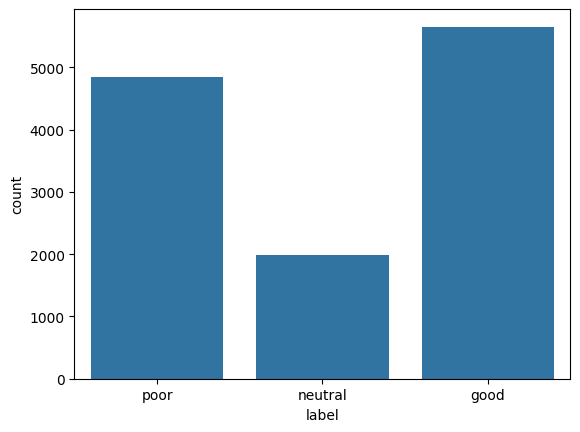

In [ ]:
# How many cases per category do we have?

import seaborn as sns

sns.countplot(x=data['label'], data=data)

**Observations:**

There are significantly fewer "neutral" instances compared to "bad" or "good," indicating the polarized nature of text data observed in online user reviews—people generally rate something as either very good or very bad in their online behavior.

There are 1858712 words combining all texts (rows).


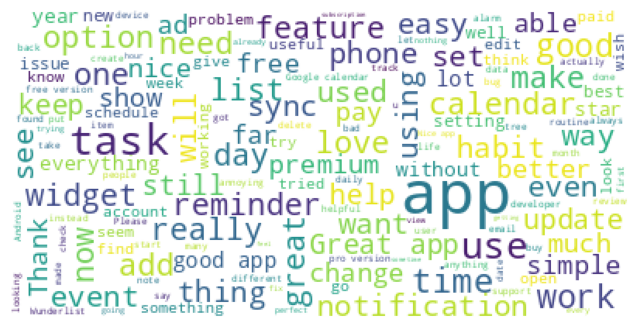

In [ ]:
# Let’s look at the 150 most common unique words in the original user reviews.

all_texts = " ".join(texts for texts in data.content)
print ("There are {} words combining all texts (rows).".format(len(all_texts)))

# Here, we are reducing max_font_size, adjust the maximum number of words, and lighten the background.**
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

There are 1,858,712 words present in the combined total text.

## **4. Data pre-processing**

Now let’s clean the data before proceeding to build the word embeddings for the text.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

*Regex expressions*

A regular expression matches a broad or specific text pattern and is strictly read from left to right.

'^' is a symbol that extracts characters starting with a given pattern.  
We apply the expression to a single data point and observe the results:

In [ ]:
data['content'][0:10]

,content
0,I cannot open the app anymore
1,I have been begging for a refund from this app...
2,Very costly for the premium version (approx In...
3,"Used to keep me organized, but all the 2020 UP..."
4,Dan Birthday Oct 28
5,It has changed how I viewed my different lists...
6,I'm only looking for a grocery list app but ev...
7,"Reset my free trial, new phone I'd like to see..."
8,How do to stop monthly payment because i don't...
9,I complain about not crashes and it was immedi...


In [ ]:
# Replacing all characters that are not letters or numbers with spaces.

print("Before applying the correction :", data['content'][3])
pattern = '[^a-zA-Z0-9]'
res = re.sub(pattern, ' ', data['content'][3])

print("After applying the correction :", res)

Before applying the correction : Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤
After applying the correction : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        


We can clearly see that we have removed special characters and numbers from the text. Additionally, we notice extra spaces in many parts of the text—let's remove them using another regular expression.

\s+: The regular expression \s is a predefined character class. It represents a single whitespace character. The plus sign + is a quantifier, meaning one or more occurrences.

In [ ]:
print("Before applying the correction :", res)
pattern = '\s+'
resf = re.sub(pattern, ' ', res)

print("After applying the correction :", resf)

Before applying the correction : Used to keep me organized  but all the 2020 UPDATES have made a mess of things     Y cudn t u leave well enuf alone     Guess ur techies feel the need to keep making changes to justify continuing to collect their salary        
After applying the correction : Used to keep me organized but all the 2020 UPDATES have made a mess of things Y cudn t u leave well enuf alone Guess ur techies feel the need to keep making changes to justify continuing to collect their salary 


We have successfully removed the extra spaces present in the text from the previous output.
  
Let’s remove numbers and other numerals from the data. The range [0-9] is not always equivalent to \d. In Python 3, [0-9] matches only the characters 0123456789, while \d matches [0-9] and other digit characters, such as Eastern Arabic numerals ٠١٢٣٤٥٦٧٨٩.

In [ ]:
# Now, let's create a for loop that will clean current data and results will be stored in
# a new feature (variable) called "final_text"

final_corpus = []

for i in range(data.shape[0]):

    # Remove numbers, special characters, and spaces.
    text = re.sub('[^a-zA-Z0-9]', ' ', data['content'][i])

    # Converting the text to lowercase.
    text = text.lower()

    # To remove the extra spaces in the data
    text = re.sub(r'\s+',' ',text)

    # To remove all digits and replace with a space ' '
    text = re.sub(r'\d',' ',text)

    # Dividing text into words
    text = text.split()

    # Removing stopwords
    text = [word for word in text if not word in stopwords.words('english')]

    # Getting together all words in text
    text = ' '.join(text)

    # Adding the final, cleaned text to "final _corpus"
    final_corpus.append(text)

data['final_text'] = final_corpus

In [ ]:
data

,content,label,final_text
0,I cannot open the app anymore,poor,cannot open app anymore
1,I have been begging for a refund from this app...,poor,begging refund app month nobody replying
2,Very costly for the premium version (approx In...,poor,costly premium version approx indian rupees pe...
3,"Used to keep me organized, but all the 2020 UP...",poor,used keep organized updates made mess things c...
4,Dan Birthday Oct 28,poor,dan birthday oct
...,...,...,...
12490,"I really like the planner, it helps me achieve...",good,really like planner helps achieve tasks goals ...
12491,😁****😁,good,
12492,Very useful apps. You must try it,good,useful apps must try
12493,Would pay for this if there were even more add...,good,would pay even additions updates absolutely lo...


Let’s look at the 150 most common unique words in the reviews where we have applied some preprocessing steps.

There are 1155388 words in the combination of all the texts. 


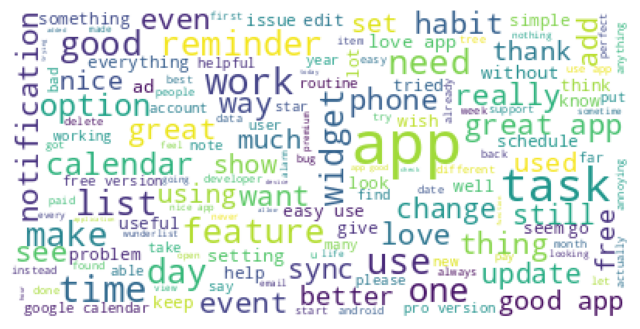

In [ ]:
all_texts1 = " ".join(texts for texts in data.final_text)
print ("There are {} words in the combination of all the texts. ".format(len(all_texts1)))

# Reduce the `max_font_size`, change the maximum number of words, and lighten the background.
wordcloud = WordCloud(max_font_size = 40, max_words = 150, background_color="white").generate(all_texts1)
plt.figure(figsize = (8,16))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Let's firts create a list of all words in the rows (reviews)

words_list =[]

for i in data['final_text']:

    li = list(i.split(" "))

    words_list.append(li)

In [ ]:
# Now take a look on the firts three rows
words_list[0:3]

[['cannot', 'open', 'app', 'anymore'],
 ['begging', 'refund', 'app', 'month', 'nobody', 'replying'],
 ['costly',
  'premium',
  'version',
  'approx',
  'indian',
  'rupees',
  'per',
  'year',
  'better',
  'download',
  'premium',
  'version',
  'app',
  'apkmos',
  'website',
  'use',
  'microsoft',
  'list',
  'app',
  'far',
  'better']]

**Creating Word Embeddings with Word2vec**

Word2vec takes the following two important parameters:

- **Min_count:** This will ignore all words with a total frequency lower than this value.  
- **Workers:** These are the processing units used to train the model.

In [ ]:
# We will bring Word2Vec classess from gensim
!pip install --user gensim==3.8.3

In [ ]:
# Let's see the current version and be sure it is the most recent
import gensim
print(gensim.__version__)

4.3.3


In [ ]:
# Now let's create our embedding model
model= Word2Vec(words_list, min_count = 1, workers = 4)                         #


# This model is calculating embeddings using CBOW by default, as this default
# sets the parameter sg=0, this indicates the use of CBOW. For using SKIPGRAM, be sure
#to include the parameter sg = 1.

In [ ]:
# We can visualize the model crated and the memory location
model

In [ ]:
# We can save the model for further use
model.save("word2vec.model")


In [ ]:
# Let's take a quick look at the words in the vocabulary:
words = model.wv.key_to_index


len(words)

10766

**Observations:**

Each word is assigned an appropriate word index from all the text present in the data.  
Let’s look at the assigned embedding of a random word using the trained model:

In [ ]:
word = "happy"
model.wv[word]

array([-1.15513429e-01,  2.59267569e-01,  2.04792351e-01,  9.17748362e-02,
        3.65830213e-02, -5.34596443e-01,  1.32341400e-01,  6.29256427e-01,
       -2.85323799e-01, -2.36324906e-01, -1.34971946e-01, -5.20113885e-01,
       -1.80766925e-01,  2.03492686e-01,  2.15789542e-01, -1.66350335e-01,
        1.07916035e-01, -3.48418027e-01, -1.00067288e-01, -6.11671031e-01,
        2.66734093e-01,  2.16320992e-01,  4.51734886e-02, -1.50617093e-01,
       -2.73619115e-01,  9.70309898e-02, -2.88575143e-01, -3.39672863e-01,
       -2.65276611e-01, -3.74458358e-02,  2.09922343e-01,  1.19711399e-01,
       -2.91850243e-04, -1.44886672e-01, -6.91241100e-02,  4.12742436e-01,
        1.54025443e-02, -3.41290027e-01, -2.19160929e-01, -7.18003631e-01,
        2.06699874e-02, -5.00580147e-02, -9.85752791e-04,  6.59806803e-02,
        2.94681519e-01, -5.59701249e-02, -4.45919365e-01, -5.95367663e-02,
        2.20229343e-01,  1.81241602e-01,  7.54411072e-02, -3.03182453e-01,
       -8.53986815e-02, -

In [ ]:
# As we have defined a dimension = 100, we have 100 positions in the vector representing the
# word "problem"
dim = model.wv[word].shape
print(dim)

(100,)


In [ ]:
# Let's look at the size of the vocabulary.
print("Size of vocabulary = ", len(list(model.wv.key_to_index)))

Size of vocabulary =  10766


In [ ]:
# The 10 words similar to the word 'happy' are:

similar = model.wv.similar_by_word('happy')
print(similar)

[('bad', 0.998916506767273), ('application', 0.9987984895706177), ('sucks', 0.998590886592865), ('planner', 0.998478353023529), ('experience', 0.9984701871871948), ('functionality', 0.9984622597694397), ('loved', 0.9982095956802368), ('beautiful', 0.9981831908226013), ('satisfied', 0.9981655478477478), ('definitely', 0.998141348361969)]


In [ ]:
# The 10 words similar to the word 'premium' are:

similar = model.wv.similar_by_word('premium')
print(similar)

[('paid', 0.9972262978553772), ('pro', 0.9937160015106201), ('free', 0.9889371395111084), ('buy', 0.9792101383209229), ('version', 0.9710708260536194), ('bought', 0.9703401327133179), ('payed', 0.9684826135635376), ('pay', 0.9649136066436768), ('full', 0.9642478227615356), ('upgraded', 0.9629424214363098)]


### **Calculating the average embeddings for every row and creating the classifier**

In [ ]:
# This code creates a dictionary that maps words to their indices in the model's vocabulary and
# then retrieves the corresponding word embeddings for those words in the Word2Vec model.

words = model.wv.key_to_index
wvs = model.wv[words]

In [ ]:
# The purpose of this routine is to calculate the averaged feature vector for the
# words in each record in `words` using the word embeddings from the model.


def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):

    vocabulary = set(model.wv.key_to_index)

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]

    return np.array(features)


feature_size = 100

# Obtener embeddings a nivel de documento
w2v_feature_array = averaged_word_vectorizer(corpus = words_list,
                                             model = model,
                                             num_features = feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.210801,0.519648,0.378526,0.189088,0.029289,-0.901590,0.073757,1.127390,-0.504199,-0.308149,...,0.929035,0.230185,-0.000491,0.345624,0.919671,0.888184,-0.173964,-0.839269,0.186493,0.191195
1,-0.089747,0.229050,0.160555,0.088268,-0.002729,-0.471019,0.073217,0.524821,-0.267230,-0.164745,...,0.437135,0.109298,-0.018571,0.165737,0.464514,0.423616,-0.098854,-0.380454,0.083923,0.089403
2,-0.149699,0.408058,0.341882,0.125394,0.026711,-0.724456,0.231475,0.861830,-0.337139,-0.413361,...,0.893624,0.059728,-0.034614,0.344130,0.744370,0.628322,-0.162951,-0.573871,0.067664,0.293259
3,-0.141237,0.274011,0.182783,0.107103,0.026506,-0.605317,0.090839,0.713204,-0.361306,-0.195401,...,0.531588,0.178582,-0.048572,0.153247,0.638891,0.521117,-0.074096,-0.485756,0.134194,0.039584
4,-0.032920,0.077822,0.065605,0.023977,0.010646,-0.134168,0.006069,0.179408,-0.079822,-0.047322,...,0.148036,0.038229,-0.005054,0.046880,0.142968,0.129180,-0.014440,-0.129259,0.032197,0.022296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,-0.130210,0.259679,0.154984,0.103605,0.024952,-0.613002,0.072512,0.716957,-0.394841,-0.194364,...,0.461538,0.221352,-0.071623,0.103801,0.654885,0.498383,-0.055869,-0.486467,0.157004,-0.030012
12491,0.008760,-0.002272,-0.006867,0.007277,0.000761,0.008345,-0.002872,-0.008380,-0.004519,0.004462,...,0.008209,0.000245,-0.000154,0.008418,0.009567,-0.004852,-0.000436,-0.004150,0.001532,-0.001190
12492,-0.204994,0.479893,0.324147,0.154646,0.087563,-0.944817,0.112400,1.135994,-0.519420,-0.358594,...,0.926663,0.239612,-0.078985,0.313758,0.980086,0.843993,-0.160581,-0.780572,0.166866,0.115677
12493,-0.162776,0.415065,0.317521,0.137049,0.040222,-0.780190,0.116116,0.989735,-0.446537,-0.331726,...,0.813606,0.189974,-0.076750,0.251093,0.849348,0.698185,-0.121824,-0.680973,0.155788,0.090842


Although some rows have fewer than 100 words, a vector (embedding) has been constructed for each row, which now displays the unique features and numbers representing the words within them.

In [ ]:
# This code uses the `LabelEncoder` class from the scikit-learn library to transform
# the labels in a column named `'label'` in our dataset `data` into numerical values.

from sklearn.preprocessing import LabelEncoder

ln = LabelEncoder()
y = ln.fit_transform(data['label'])
y

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
# Print the mapping of numerical labels to original categories
for index, category in enumerate(ln.classes_):
    print(f"{index} -> {category}")

0 -> good
1 -> neutral
2 -> poor


Once we have pre-processed and created embeddings for each row in our dataset, we are ready to train our model (Random Forest), following the creation of our test-train split.

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(w2v_feature_array,y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9996, 100), (2499, 100), (9996,), (2499,))

In [ ]:
# Let's see the number of observations in each sample and the amount of
# classes in each.
# Describing the number of observations
print("Number of observations TRAIN:")
print(f"Training data: {len(X_train)}")
print(f"Test data: {len(X_test)}")
print( '---------------------------------------------------')
print(f"Training data (labels): {len(y_train)}")
print(f"Validation data (labels): {len(y_test)}")
print('NOTE: In this case, "validation" equals to "test"')
print( '---------------------------------------------------')
# Checking class distribution
print("\nClass distribution in each partition:")
print(f"Training classes y_train:\n{pd.Series(y_train).value_counts()}")
print(f"Validation classes y_test:\n{pd.Series(y_test).value_counts()}")

Number of observations TRAIN:
Training data: 9996
Test data: 2499
---------------------------------------------------
Training data (labels): 9996
Validation data (labels): 2499
NOTE: In this case, "validation" equals to "test"
---------------------------------------------------

Class distribution in each partition:
Training classes y_train:
0    4534
2    3892
1    1570
Name: count, dtype: int64
Validation classes y_test:
0    1120
2     958
1     421
Name: count, dtype: int64


In [ ]:
# Initializing the Random Forest model.
model_w2v = RandomForestClassifier(random_state = 7)

# Fitting the model to the training set.
model_w2v.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

Let's see now the results on Test, the Classification report and the Confusion Matrix.

Results for W2Vec embeddings
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1120
           1       0.29      0.03      0.05       421
           2       0.61      0.76      0.68       958

    accuracy                           0.65      2499
   macro avg       0.53      0.52      0.49      2499
weighted avg       0.59      0.65      0.60      2499



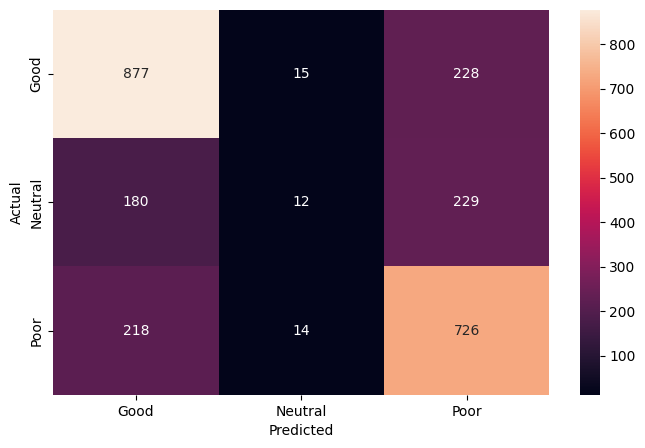

In [ ]:
# Making predictions on the test set.
y_pred = model_w2v.predict(X_test)
print('======================================================================================================================')
print('Results for W2Vec embeddings')
print('======================================================================================================================')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f',xticklabels=['Good', 'Neutral', 'Poor'], yticklabels=['Good', 'Neutral', 'Poor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## **6. GloVe embeddings and model deployment**

***Global Vectors for Word Representation***, also known as GloVe, is an alternative to Word2vec. Like Word2vec, it is an unsupervised learning algorithm that allows us to take a text corpus and intuitively map each word in the document to a position in a high-dimensional latent space, providing us with the vector representation of the word.

Let’s now create the embeddings using GloVe with a pre-trained base.

The exercise requires "unpacking" the file *glove.6B.300d.rar* (glove.6B.300d.txt) and uploading it to the location `/content/drive/MyDrive/` in your Drive space to load the vectors. Using these "pre-trained" vectors offers many advantages in model development. These vectors are pre-trained on large text corpora (such as Wikipedia and Common Crawl). This means they already capture semantic and contextual relationships between words without the need to train from scratch. This saves time and resources. See: (https://nlp.stanford.edu/projects/glove/)

In [ ]:
# Download the GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip





--2024-11-21 22:05:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-21 22:05:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-21 22:05:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -j glove.6B.zip glove.6B.300d.txt -d /content/


Archive:  glove.6B.zip
  inflating: /content/glove.6B.300d.txt  


In [ ]:
# Loading the GloVe vectors into a dictionary:

embeddings_index = {}
f = open(r'/content/glove.6B.300d.txt', encoding="utf8")

for line in tqdm(f):
    # Splitting each line.
    values = line.split()

    word = values[0]

    coefs = np.array(values[1:], dtype='float32')

    embeddings_index[word] = coefs

f.close()

print('%s word vectors found.' % len(embeddings_index))

400000it [00:39, 10122.00it/s]

400000 word vectors found.


In [ ]:
# This function creates a normalized vector for all the rows in the database.

def sent2vec(s):
    words = word_tokenize(s)
    N = []
    for w in words:
        try:
            N.append(embeddings_index[w])
        except:
            continue
    N = np.array(N)
    v = N.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# Let's take a quick look at the independent features.

data.final_text.values

array(['cannot open app anymore',
       'begging refund app month nobody replying',
       'costly premium version approx indian rupees per year better download premium version app apkmos website use microsoft list app far better',
       ..., 'useful apps must try',
       'would pay even additions updates absolutely love wish would develop even',
       'sooow good'], dtype=object)

In [ ]:
# Let's encode the labels
y = ln.fit_transform(data['label'])
y

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
# Print the mapping of numerical labels to original categories
for index, category in enumerate(ln.classes_):
    print(f"{index} -> {category}")

0 -> good
1 -> neutral
2 -> poor


In [ ]:
# It is time to create our trai-test split usng our row text data
xtrain, xvalid, ytrain, yvalid = train_test_split(data.final_text.values, y,
                                                  stratify = y,
                                                  random_state = 42,
                                                  test_size = 0.2, shuffle = True)

In [ ]:
# Let's see the number of observations in each sample and the amount of
# classes in each.
# Describing the number of observations
print("Number of observations:")
print(f"Training data (xtrain): {len(xtrain)}")
print(f"Validation data (xvalid): {len(xvalid)}")
print( '---------------------------------------------------')
print(f"Training data (ytrain): {len(ytrain)}")
print(f"Validation data (yvalid): {len(yvalid)}")
print('NOTE: In this case, "validation" equals to "test"')
print( '---------------------------------------------------')
# Checking class distribution
print("\nClass distribution in each partition:")
print(f"Training classes ytrain:\n{pd.Series(ytrain).value_counts()}")
print(f"Validation classes yvalid:\n{pd.Series(yvalid).value_counts()}")

Number of observations:
Training data (xtrain): 9996
Validation data (xvalid): 2499
---------------------------------------------------
Training data (ytrain): 9996
Validation data (yvalid): 2499
NOTE: In this case, "validation" equals to "test"
---------------------------------------------------

Class distribution in each partition:
Training classes ytrain:
0    4523
2    3880
1    1593
Name: count, dtype: int64
Validation classes yvalid:
0    1131
2     970
1     398
Name: count, dtype: int64


In [ ]:
print("Shape del Training set : ", xtrain.shape)

print("Shape del test set : ", xvalid.shape)

Shape del Training set :  (9996,)
Shape del test set :  (2499,)


In [ ]:
# Create sentence vectors using the previous function (sent2vec) for the training and validation sets.
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 2499/2499 [00:01<00:00, 1856.79it/s]


In [ ]:
# Let's see the corresponding embedding for the first row in our dataset
xtrain_glove[0]

array([-6.11750856e-02,  5.93502074e-02,  2.91651804e-02, -2.72422899e-02,
        7.61484634e-03,  2.83922013e-02, -3.48623507e-02, -3.19210254e-02,
       -3.96693051e-02, -2.96207756e-01,  6.71017468e-02,  1.19364299e-02,
       -7.42687136e-02,  1.15761265e-01,  1.78379845e-02, -2.76399720e-02,
       -5.93165234e-02,  4.55704192e-03,  3.16841505e-03, -5.36923669e-02,
        1.31615279e-02,  5.17453589e-02, -1.43935820e-02,  8.55733007e-02,
       -2.53371131e-02, -3.09500769e-02,  6.58457226e-04, -3.20448950e-02,
        1.97723918e-02, -2.28410065e-02, -5.01013920e-02,  8.54103193e-02,
       -5.31842895e-02, -3.64215765e-03, -2.54812986e-01,  9.28239375e-02,
        2.84211021e-02, -4.48467731e-02, -5.85161615e-04,  4.61137015e-03,
       -9.52187181e-03, -1.11584505e-02,  3.36654186e-02,  7.75338262e-02,
       -1.17177600e-02,  1.05027100e-02,  3.46999131e-02,  7.82730132e-02,
        1.72882937e-02,  5.52082341e-03,  1.80901762e-03, -1.38688860e-02,
        5.87384701e-02, -

In [ ]:
xtrain_glove[0].shape

(300,)

Finally, we have stored all embeddings for each row in our dataset in the variable xtrain_glove. Each row is now represented as a vector of 300 positions, corresponding to the 300 dimensions inherited from the GloVe pre-trained file used.

In [ ]:
# Initializing the Random Forest model.
model_glo = RandomForestClassifier(random_state = 7)

# Fitting the model to the training set.
model_glo.fit(xtrain_glove,ytrain)

RandomForestClassifier(random_state=7)

Results for GloVe embeddings
              precision    recall  f1-score   support

           0       0.73      0.81      0.76      1131
           1       0.44      0.01      0.02       398
           2       0.63      0.80      0.70       970

    accuracy                           0.68      2499
   macro avg       0.60      0.54      0.50      2499
weighted avg       0.64      0.68      0.62      2499



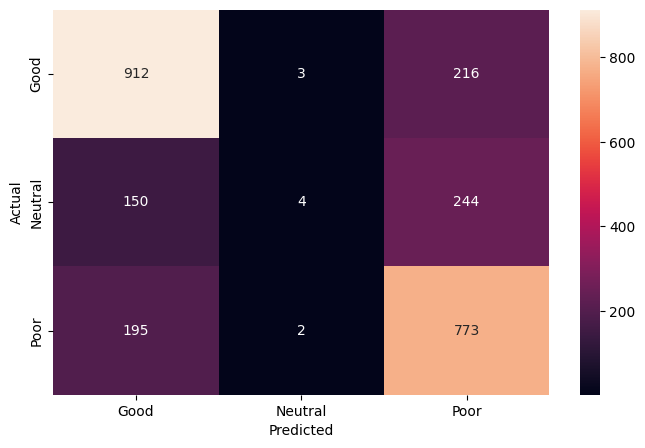

In [ ]:
# Making predictions on the test set.
y_pred_glo = model_glo.predict(xvalid_glove)
print('======================================================================================================================')
print('Results for GloVe embeddings')
print('======================================================================================================================')
print(classification_report( yvalid, y_pred_glo))

# Creating the Confusion Matrix
cm = confusion_matrix(yvalid, y_pred_glo)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f',xticklabels=['Good', 'Neutral', 'Poor'], yticklabels=['Good', 'Neutral', 'Poor'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



#xtrain, xvalid, ytrain, yvalid

## **Conclusions**

Both models differ in how they are trained and, therefore, produce different word vectors.

The GloVe model is based on global word-to-word co-occurrence counts considering the entire corpus, while Word2vec uses the co-occurrence of local context (neighboring words).

GloVe learns its embeddings by constructing the global co-occurrence matrix, whereas the Word2vec model learns by making predictions using context words as inputs and predicting target words.

This approach overcomes many of the issues with simple one-hot vector encodings, such as BofW and tf-idf.

Most importantly, embeddings enhance generalization and performance for virtually any natural language processing problem, especially when there is limited training data available.

## **THANK YOU**